In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
import pickle
import nltk
import spacy
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
import torch
from torch.utils.data import Dataset, DataLoader
import torchtext

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:


class TextProcessor:
    def __init__(self, data_file: str, freq_threshold: int = 5):
        """
        Initializes a TextProcessor object.

        Args:
            data_file (str): The path to the CSV file containing the text data.
            freq_threshold (int, optional): The frequency threshold for word occurrence. Defaults to 5.
        """
        self.data_file = data_file
        self.dataset = pd.read_csv(data_file)
        self.freq_threshold = freq_threshold

    def process_text(self) -> tuple:
        """
        Processes the text data.

        Returns:
            tuple: A tuple containing:
                - token_mappings (list of lists): Token mappings for each sentence in the dataset.
                - reverse_word_mapper (dict): Mapping from index to word.
        """
        spacy.prefer_gpu()

        text_tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
        tokenized_text = []
        sentence_groups = []
        for entry in self.dataset['text'].tolist():
            tokenized_text.append(text_tokenizer(entry))
            sentence_groups.append(entry.split('.'))

        self.dataset['grouped_sentences'] = sentence_groups

        word_counter = Counter()
        for line in tokenized_text:
            for word in line:
                word_counter[word] += 1

        word_mapper = {word[0]: idx+1 for idx, word in enumerate(word_counter.most_common())}
        reverse_word_mapper = {idx+1: word[0] for idx, word in enumerate(word_counter.most_common())}
        other_index = len(word_counter.keys())

        token_mappings = []
        for line in tokenized_text:
            mapped_line = []
            for word in line:
                mapped_line.append(word_mapper.get(word, other_index))
            token_mappings.append(mapped_line)

        return token_mappings, reverse_word_mapper





In [ ]:
def compute_paragraph_similarity(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the similarity scores between consecutive sentences within each paragraph.

    Args:
        dataset (pd.DataFrame): The dataset containing text data.

    Returns:
        pd.DataFrame: The dataset with similarity scores added as a new column.
    """
    similarity_scores = []
    for paragraph in dataset['grouped_sentences'].tolist():
        similarity = 200
        initial_sentence = paragraph[0]
        paragraph = paragraph[1:]
        for sentence in paragraph:
            tokenized_initial = word_tokenize(initial_sentence)
            tokenized_current = word_tokenize(sentence)

            sw = set(stopwords.words('english'))
            initial_set = {w for w in tokenized_initial if not w in sw}
            current_set = {w for w in tokenized_current if not w in sw}

            combined_set = initial_set.union(current_set)
            vector1 = [1 if w in initial_set else 0 for w in combined_set]
            vector2 = [1 if w in current_set else 0 for w in combined_set]

            dot_product = sum(i * j for i, j in zip(vector1, vector2))
            try:
                cosine_similarity = dot_product / float((sum(vector1)*sum(vector2))**0.5)
                if similarity > cosine_similarity:
                    similarity = cosine_similarity
            except ZeroDivisionError:
                similarity += 0

            initial_sentence = sentence

        similarity_scores.append(similarity)

    dataset['similarity_scores'] = similarity_scores

    return dataset

In [ ]:
base_path = '/content/gdrive/MyDrive/Inlp-Project/Datasets/GCDC_rerelease/'

# Training data
data1 = pd.read_csv(base_path + 'Clinton_train.csv')
data2 = pd.read_csv(base_path + 'Yahoo_train.csv')
data3 = pd.read_csv(base_path + 'Yelp_train.csv')
data4 = pd.read_csv(base_path + 'Enron_train.csv')

# Test data
data5 = pd.read_csv(base_path + 'Clinton_train.csv')
data6 = pd.read_csv(base_path + 'Yahoo_test.csv')
data7 = pd.read_csv(base_path + 'Enron_test.csv')
data8 = pd.read_csv(base_path + 'Yelp_test.csv')


In [ ]:
data1 = pd.concat([data1, data2, data3, data4, data5, data6])
data2 = pd.concat([data7,data8])


In [ ]:
data1.to_csv(base_path+'/combined_train.csv')
data2.to_csv(base_path+'/combined_test.csv')

In [ ]:
train = TextProcessor(base_path+"combined_train.csv")
test = TextProcessor(base_path+"combined_test.csv")


In [ ]:
train_size = len(train.dataset)
test_size = len(test.dataset)

# Print the sizes
print("Size of train dataset:", train_size)
print("Size of test dataset:", test_size)

Size of train dataset: 5200
Size of test dataset: 400


In [ ]:
train_labels = np.array(train.dataset['labelA'])
train_encoded_labels = to_categorical(train_labels)
print("Original Labels:")
print(train_labels)
print("\nOne-Hot Encoded Labels:")
print(train_encoded_labels)

Original Labels:
[2 2 3 ... 3 1 3]

One-Hot Encoded Labels:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [ ]:
test_labels = np.array(test.dataset['labelA'])
test_encoded_labels = to_categorical(test_labels)

print("Original Labels for Test Dataset:")
print(test_labels)
print("\nOne-Hot Encoded Labels for Test Dataset:")
print(test_encoded_labels)

Original Labels for Test Dataset:
[3 1 3 1 3 1 2 2 3 3 3 2 3 2 1 1 1 1 1 3 3 3 3 3 2 2 1 1 3 3 2 3 3 3 1 3 3
 2 2 2 2 3 3 2 3 3 2 1 2 3 3 3 2 2 1 1 3 3 1 1 2 2 2 1 3 3 1 1 1 3 1 2 3 1
 3 1 3 3 1 1 2 3 1 2 1 3 3 1 2 2 3 3 3 1 1 2 3 3 3 3 3 1 3 2 1 3 1 3 2 3 2
 1 1 2 3 3 3 3 1 3 3 3 3 1 1 2 3 2 2 2 2 3 3 1 3 2 2 2 3 1 2 3 2 2 1 2 3 3
 1 3 1 3 2 1 2 3 1 3 3 1 1 3 3 1 2 1 3 3 2 1 2 1 1 1 1 1 1 1 3 2 1 3 3 3 3
 2 3 3 1 3 3 1 2 3 3 3 1 3 2 1 1 1 1 3 3 3 2 3 1 1 2 3 1 3 2 3 3 1 3 3 3 3
 3 1 3 3 1 3 1 2 3 3 3 3 3 3 1 3 3 3 3 2 3 2 3 3 2 2 1 1 3 1 3 2 3 3 3 2 2
 3 1 2 3 1 2 2 3 3 2 3 2 2 1 3 3 2 3 3 2 3 3 2 2 1 3 1 3 2 3 2 3 2 1 3 1 3
 1 1 3 3 1 3 1 3 3 1 3 3 3 1 3 1 3 1 1 3 2 3 2 3 3 3 3 3 2 2 2 3 2 3 3 3 3
 3 1 3 3 1 3 3 3 1 3 3 3 1 2 3 3 1 1 1 3 2 2 2 1 1 1 3 3 3 1 1 1 3 3 2 1 3
 1 3 2 2 3 3 3 2 2 3 3 3 3 3 3 1 1 1 3 1 3 3 2 1 3 3 2 3 3 2]

One-Hot Encoded Labels for Test Dataset:
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [ ]:
train_mapped_tokens, train_inverse_mapper = train.process_text()
test_mapped_tokens, test_inverse_mapper = test.process_text()


In [ ]:
print("Processed Data for Training Dataset:")
print(train_mapped_tokens[:1])
print("Inverse Mapper for Training Dataset:")
print(train_inverse_mapper)

print("\nProcessed Data for Testing Dataset:")
print(test_mapped_tokens[:1])
print("Inverse Mapper for Testing Dataset:")
print(test_inverse_mapper)


Processed Data for Training Dataset:
[[304, 83, 14, 1698, 22, 9, 6, 81, 113, 4, 768, 4209, 4, 467, 5918, 3047, 64, 103, 16, 15094, 9, 784, 72, 14, 98, 48, 3, 7, 39, 452, 22, 265, 75, 4, 387, 16, 784, 2260, 5, 7, 27, 60, 2, 10552, 353, 4, 337, 2, 4209, 1, 220, 27, 20, 2307, 4, 91, 15, 2308, 225, 3, 77, 27, 4210, 75, 4, 917, 1593, 15, 3251, 3, 2204, 942, 15095, 3, 299, 1, 3, 5, 24, 2308, 149, 887, 27, 2067, 75, 183, 2, 240, 8, 2, 518, 16, 871, 507, 3, 3252, 1, 119, 462, 39, 180, 49, 378, 225, 47, 48, 8, 4970, 145, 6, 5568, 2031, 15, 5919, 16, 889, 1333, 1, 14, 7, 93, 28, 3048, 16, 9475, 59, 4, 5919, 148, 2, 1966, 22, 60, 2, 71, 53, 12, 4, 20, 232, 3, 5, 22, 128, 28, 60, 1939, 34, 2109, 59, 34, 145, 22, 2350, 33, 28, 6, 15096, 15097, 1394, 3, 201, 22, 51, 366, 1894, 11, 2871, 15, 1067, 47, 871, 30, 1, 175, 3, 46, 2, 2205, 23, 9, 113, 3, 4672, 5, 7, 39, 69, 4, 96, 59, 1434, 25, 889, 9, 235, 4, 1790, 9, 10553, 585, 16, 889, 2463, 25, 499, 1, 14, 206, 6873, 25, 9, 2206, 12, 924, 15, 889, 100

In [ ]:
train.dataset['encoding'] = train_mapped_tokens
test.dataset['encoding'] = test_mapped_tokens

In [ ]:
train.dataset

,Unnamed: 0,text_id,subject,text,ratingA1,ratingA2,ratingA3,labelA,ratingM1,ratingM2,ratingM3,ratingM4,ratingM5,labelM,question_title,question,grouped_sentences,encoding
0,0,C05796441_2,NaN,Cheryl:\n\nAre we in a good place to begin pap...,3,2,1,2,2,2,3,1,2,2,NaN,NaN,[Cheryl:\n\nAre we in a good place to begin pa...,"[304, 83, 14, 1698, 22, 9, 6, 81, 113, 4, 768,..."
1,1,C05786430_1,Department of State,"Our friend, General Joe Ballard owns The Raven...",2,1,3,2,3,2,3,1,3,3,NaN,NaN,"[Our friend, General Joe Ballard owns The Rave...","[404, 407, 3, 843, 1853, 6874, 4211, 31, 8287,..."
2,2,C05780653_3,NaN,Outstanding news! Miki Rakic called about 10 m...,2,3,3,3,2,2,3,2,3,3,NaN,NaN,[Outstanding news! Miki Rakic called about 10 ...,"[12776, 503, 40, 10554, 15102, 241, 52, 378, 3..."
3,3,C05782181_1,Libyan CG Pol Dirs mtg @ Istanbul @ 14:00 Thur...,Responding to separate emails from Uzra + Jeff...,1,2,1,1,2,2,1,3,1,1,NaN,NaN,[Responding to separate emails from Uzra + Jef...,"[15115, 4, 1451, 2465, 41, 10556, 942, 555, 83..."
4,4,C05785147_0,Mexico,Guy from Mexico is in NY and is cooperating. D...,2,1,1,1,1,1,2,3,1,1,NaN,NaN,"[Guy from Mexico is in NY and is cooperating, ...","[4973, 41, 805, 12, 9, 1243, 5, 12, 4974, 1, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,195,text886T,NaN,Being a 5th generation Californian now residin...,2,2,1,1,3,3,1,2,3,3,What do you think of Califorina?,i have lived in NorthCaliforina for my whole l...,[Being a 5th generation Californian now residi...,"[3129, 6, 3667, 2586, 14126, 115, 34896, 9, 13..."
5196,196,text189PG,NaN,"that means they haven't ""taken away your right...",1,1,2,1,2,1,2,1,3,1,how can a court system take my rights away wit...,i got papers saying there will be a hearing to...,"[that means they haven't ""taken away your righ...","[11, 742, 36, 19, 37, 34, 625, 318, 42, 526, 3..."
5197,197,text1221T,NaN,I have never heard of the travel agent you are...,3,3,3,3,3,1,2,2,2,2,how do I find out about track record for a par...,i am looking for information on isramworld wha...,[I have never heard of the travel agent you ar...,"[7, 19, 213, 400, 8, 2, 642, 2762, 13, 23, 537..."
5198,198,text220AH,NaN,"i think those who don't really have ""faith"" us...",1,2,1,1,1,1,3,1,2,1,"Why do christians use the word ""faith"" everytime?","i mean like , christians(which i used to be) a...","[i think those who don't really have ""faith"" u...","[132, 85, 200, 80, 38, 37, 127, 19, 34, 1232, ..."


In [ ]:
test.dataset

,Unnamed: 0,text_id,subject,text,ratingA1,ratingA2,ratingA3,labelA,ratingM1,ratingM2,ratingM3,ratingM4,ratingM5,labelM,grouped_sentences,encoding
0,0,1144932,"Asset Dispositions--""Success Fees""",Mark and Jeff: There is an impression circulat...,3,2,2,3,2,2,3,3,1,2,[Mark and Jeff: There is an impression circula...,"[451, 5, 509, 138, 144, 12, 60, 1238, 4195, 21..."
1,1,19947,new rolls,"Brian,\n\nIn an effort to keep things consiste...",3,1,1,1,2,2,1,1,3,1,"[Brian,\n\nIn an effort to keep things consist...","[1440, 3, 16, 151, 60, 723, 4, 226, 207, 1244,..."
2,2,1303171,College Football Pool,We are putting together a college football poo...,3,2,3,3,2,3,3,2,2,3,[We are putting together a college football po...,"[53, 32, 953, 347, 8, 2134, 2850, 2135, 11, 35..."
3,3,894625,Bengalla Biz,We seem to be going round in circle's here and...,2,2,1,1,2,1,2,1,2,1,[We seem to be going round in circle's here an...,"[53, 956, 4, 22, 117, 1442, 10, 2860, 26, 76, ..."
4,4,1251040,New Contract System - Impact on One-part/Two-p...,Please be advised that we successfully convert...,3,3,3,3,3,3,2,2,3,3,[Please be advised that we successfully conver...,"[216, 22, 1253, 11, 18, 2861, 2862, 1082, 300,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,195,Ld1-4STmN0Qe-xVyX5N8Iw,In-N-Out Burger,Let's face it! Most every burger aficionado in...,2,2,3,3,1,3,3,2,3,3,[Let's face it! Most every burger aficionado i...,"[399, 26, 887, 15, 25, 2068, 272, 277, 8892, 8..."
396,196,XZbkHGhOo_Pu-ypw4j_bvw,Rent-A-Wheel,Filled out an application online got a call fr...,1,3,2,2,2,2,1,3,2,2,[Filled out an application online got a call f...,"[8921, 49, 60, 1331, 4186, 108, 8, 168, 48, 28..."
397,197,sB-Lx1QF2hI8yQpb_SdINA,Executive Hotel Cosmopolitan,Stayed here over the Christmas holidays and se...,2,2,3,3,3,2,2,2,3,3,[Stayed here over the Christmas holidays and s...,"[8932, 76, 123, 2, 8933, 2381, 5, 1456, 43, 8,..."
398,198,GifRhXPlxytoRkhyEWbqjQ,Chelsea's Kitchen,The patio is a great place to sit back and enj...,2,2,3,3,2,3,3,3,2,3,[The patio is a great place to sit back and en...,"[24, 1229, 12, 8, 93, 63, 4, 636, 71, 5, 499, ..."


In [ ]:

np.random.seed(7)
X_train = sequence.pad_sequences(train.dataset['encoding'],maxlen = 500)
y_train = train_encoded_labels
X_test = sequence.pad_sequences(test.dataset['encoding'],maxlen=500)
y_test = test_encoded_labels

In [ ]:

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from keras.optimizers import Adam

# Parameters
embedding_vector_length = 32
vocab_size = 40000
input_length = 500

# Model definition
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_vector_length, input_length=input_length),
    GRU(32, dropout=0.2, return_sequences=True),
    GRU(32),
    Dense(4, activation='softmax')
])

# Model compilation
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
gru_model.summary()

# Training the model
history = gru_model.fit(X_train, y_train, epochs=20, batch_size=16)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           1280000   
                                                                 
 gru (GRU)                   (None, 500, 32)           6336      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 1292804 (4.93 MB)
Trainable params: 1292804 (4.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 39s 201ms/step - loss: 0.4886 - accuracy: 0.4767
Epoch 2/20
163/163 [===========================

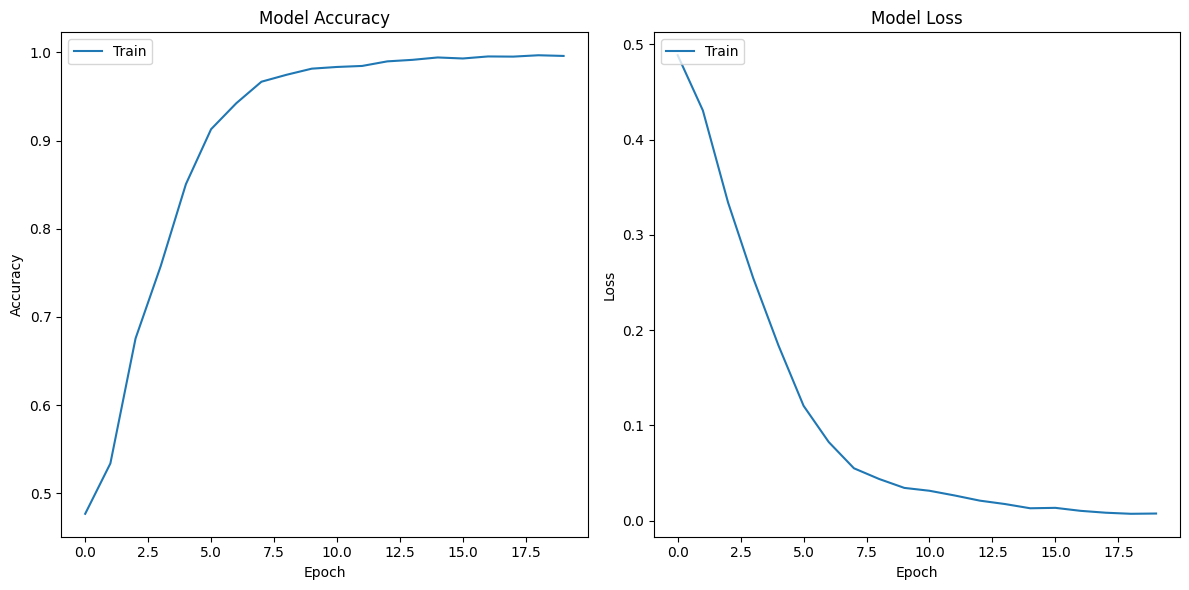

Accuracy: 34.00%


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

gru_scores = gru_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(gru_scores[1] * 100))


#Transforming three-label data into binary-label data









In [ ]:
# Creating binary labels for the training data
train_coh_bin = []
for i in range(5200):
    if train.dataset['labelA'].tolist()[i] >= 2:
        train_coh_bin.append(1)
    else:
        train_coh_bin.append(0)

train.dataset['coh_bin'] = train_coh_bin

# Creating binary labels for the test data
test_coh_bin = []
for i in range(400):
    if test.dataset['labelA'].tolist()[i] >= 2:
        test_coh_bin.append(1)
    else:
        test_coh_bin.append(0)

test.dataset['coh_bin'] = test_coh_bin


In [ ]:
# Convert binary labels to numpy array
train_bin_coh_array = np.array(train.dataset['coh_bin'])

# Convert binary labels to one-hot encoded format for training data
train_encoded = to_categorical(train_bin_coh_array)

# Convert binary labels to numpy array
test_bin_coh_array = np.array(test.dataset['coh_bin'])

# Convert binary labels to one-hot encoded format for test data
test_encoded = to_categorical(test_bin_coh_array)


In [ ]:
np.random.seed(7)
X_train = sequence.pad_sequences(train.dataset['encoding'],maxlen = 500)
y_train = train_encoded
X_test = sequence.pad_sequences(test.dataset['encoding'],maxlen=500)
y_test = test_encoded




In [ ]:

# Parameters
embedding_vector_length = 32
vocab_size = 40000
input_length = 500

# Model definition
binary_gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_vector_length, input_length=input_length),
    GRU(32, dropout=0.2, return_sequences=True),
    GRU(32),
    Dense(2, activation='softmax')
])

# Model compilation
binary_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
binary_gru_model.summary()

# Training the model
history = binary_gru_model.fit(X_train, y_train, epochs=15, batch_size=32)




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 500, 32)           6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1292738 (4.93 MB)
Trainable params: 1292738 (4.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
163/163 [==============================] - 39s 185ms/step - loss: 0.6243 - accuracy: 0.6763
Epoch 2/15
163/163 [=========================

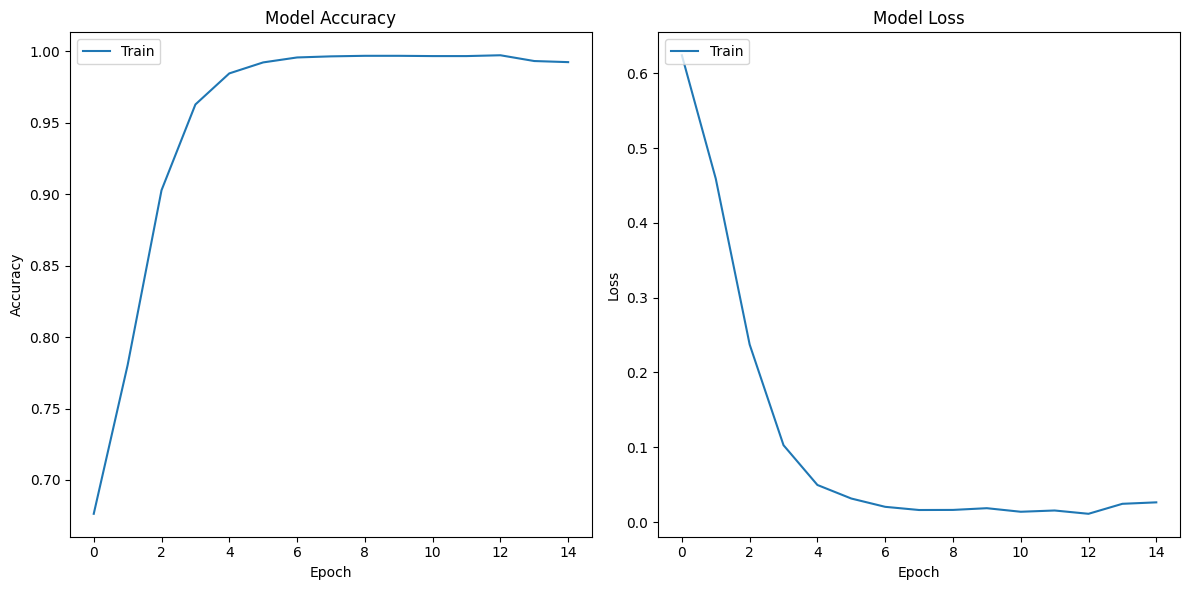

Accuracy: 63.25%


In [ ]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

gru_scores = binary_gru_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(gru_scores[1] * 100))


In [ ]:
train.dataset = compute_paragraph_similarity(train.dataset)
test.dataset = compute_paragraph_similarity(test.dataset)

# Utilizing a dataset labeled in binary format along with similarity measurements




In [ ]:
train.dataset['similarity_scores']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
5195      0.000000
5196    200.000000
5197      0.000000
5198      0.111111
5199      0.000000
Name: similarity_scores, Length: 5200, dtype: float64

In [ ]:
np.random.seed(7)

X_train = sequence.pad_sequences(train.dataset['encoding'], maxlen=500)
X_test = sequence.pad_sequences(test.dataset['encoding'], maxlen=500)

y_train = train_encoded
y_test = test_encoded

similarity_train = np.array(train.dataset['similarity_scores'])
similarity_test = np.array(test.dataset['similarity_scores'])

similarity_train = similarity_train[:, np.newaxis]
similarity_test = similarity_test[:, np.newaxis]

X_train = np.append(similarity_train, X_train, axis=1)
X_test = np.append(similarity_test, X_test, axis=1)


In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from keras.optimizers import Adam

# Parameters
embedding_vector_length = 32
vocab_size = 40000
input_length = 501

# Model definition
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_vector_length, input_length=input_length),
    GRU(32, dropout=0.2, return_sequences=True),
    GRU(32),
    Dense(2, activation='softmax')
])

# Model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 501, 32)           1280000   
                                                                 
 gru_4 (GRU)                 (None, 501, 32)           6336      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1292738 (4.93 MB)
Trainable params: 1292738 (4.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
163/163 [==============================] - 25s 130ms/step - loss: 0.6248 - accuracy: 0.6760
Epoch 2/15
163/163 [=========================

Accuracy: 66.25%


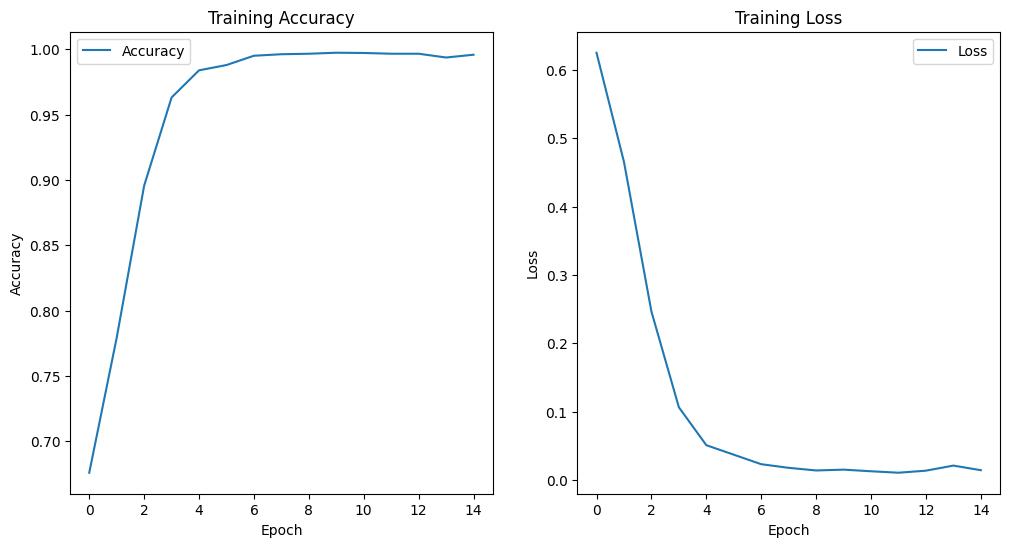

In [ ]:
# Evaluating the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(scores[1] * 100))

# Plotting training accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
gru_model.save('/content/gdrive/MyDrive/Inlp-Project/saved models/gru_model.keras')
binary_gru_model.save('/content/gdrive/MyDrive/Inlp-Project/saved models/binary_gru.keras')
model.save('/content/gdrive/MyDrive/Inlp-Project/saved models/gru_with_sim_score.keras')



### Model Overview

1. **Standard GRU Model (`gru_model`):**
   - **Accuracy:** 34.00%
   - **Loss:** Improved over 20 epochs, indicating good learning.
   - **Issue:** The final accuracy is relatively low, which might suggest overfitting, insufficient model complexity, or issues with the training data.

2. **Binary Classification GRU Model (`binary_gru_model`):**
   - **Accuracy:** 63.25%
   - **Loss:** Decreased consistently over 15 epochs, which is a good sign of learning.
   - **Note:** Better performance compared to the standard GRU model, possibly due to the binary nature simplifying the task.

3. **GRU Model with Adjusted Input Length (`model` with similarity scores):**
   - **Accuracy:** 66.25%
   - **Loss:** Consistent improvement over 15 epochs.
   - **Improvement:** using similarity measurement improved accuracy


